# Data Distribution of FOL2NS

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import T5Tokenizer

In [2]:
FOL2NS_dataset = pd.read_json(
    "FOL2NS.json",
    orient="records",
    lines=True
)

In [6]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")
Train, Dev = train_test_split(FOL2NS_dataset, test_size=0.2, random_state=30, shuffle=True)
X_train, Y_train = Train['input'].tolist(), Train['output'].tolist()
X_dev, Y_dev = Dev['input'].tolist(), Dev['output'].tolist()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
def tokenized_text(text):
  tokenization = tokenizer(text, return_tensors="pt", padding="longest", truncation=True, max_length=386)
  return tokenization.input_ids

In [9]:
x_train = tokenized_text(X_train)
y_train = tokenized_text(Y_train)
x_dev = tokenized_text(X_dev)
y_dev = tokenized_text(Y_dev)

In [ ]:
vocab_size = max(x_train.max(), x_dev.max(), y_train.max(), y_dev.max()).item() + 1

In [ ]:
def KL_divergence(p, q, eps=1e-8):
    p = p + eps
    q = q + eps
    return torch.sum(p * torch.log(p / q)).item()

In [ ]:
def plot(dist,label,color,top_n=1000):
    plt.figure(figsize=(12, 4))
    plt.plot(dist[:top_n].numpy(), label=label, color=color, alpha=0.7)
    plt.title(f"Token Frequency Distribution")
    plt.xlabel("Token id")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
def plot_token_distribution(a, b, label_a, label_b, max_id=vocab_size, top_n=1000, ignore_token_ids=[0]):
    a_flat = a.clone().detach().long().flatten()
    b_flat = b.clone().detach().long().flatten()
    
    if ignore_token_ids:
        for token_id in ignore_token_ids:
            a_flat = a_flat[a_flat != token_id]
            b_flat = b_flat[b_flat != token_id]

    a_hist = torch.bincount(a_flat, minlength=max_id).float()
    b_hist = torch.bincount(b_flat, minlength=max_id).float()

    a_dist = a_hist / a_hist.sum()
    b_dist = b_hist / b_hist.sum()

    KL_ab = KL_divergence(a_dist, b_dist)
    KL_ba = KL_divergence(b_dist, a_dist)

    print(f"{label_a} vs {label_b}: KL(P||Q): {KL_ab:.4f}; KL(Q||P): {KL_ba:.4f}")
    plot(a_dist,label_a,color="red")
    plot(b_dist,label_b,color="blue")

In [ ]:
def distributions(x_train, x_dev, y_train, y_dev, vocab_size=30000, emb_dim=64):
    plot_token_distribution(x_train, x_dev, "x_train", "x_dev", max_id=vocab_size)
    plot_token_distribution(y_train, y_dev, "y_train", "y_dev", max_id=vocab_size)

x_train vs x_dev: KL(P||Q): 0.5094; KL(Q||P): 0.2186


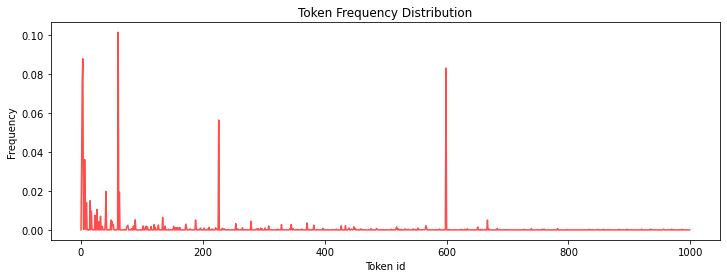

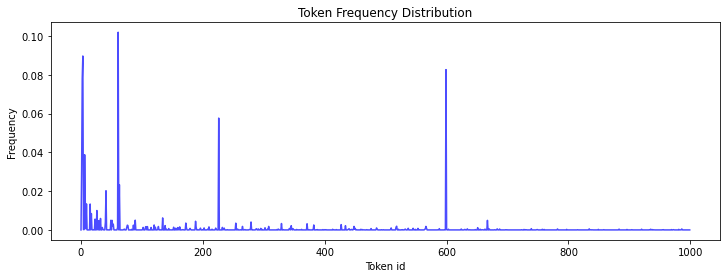

y_train vs y_dev: KL(P||Q): 1.1563; KL(Q||P): 0.4896


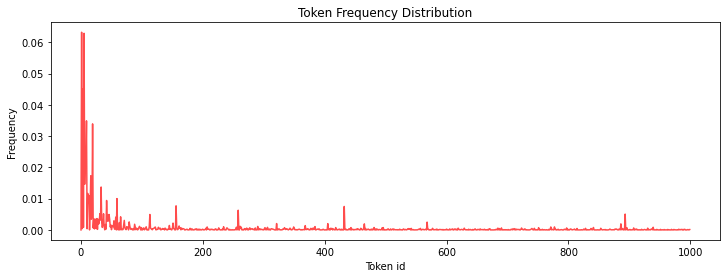

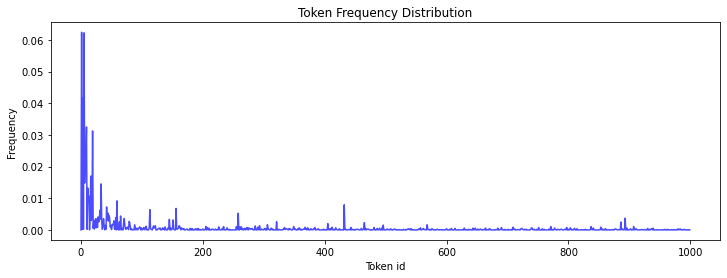

In [33]:
distributions(x_train, x_dev, y_train, y_dev)